In [1]:
from __future__ import print_function, division
import os

import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt

import argparse

# 경고 메시지 무시하기
import warnings
warnings.filterwarnings("ignore")

(280, 300, 3)

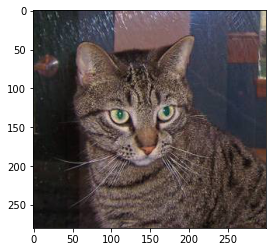

In [2]:
import matplotlib.image as img

file_name = 'datasets/training_set/training_set/cats/cat.1.jpg'
image = img.imread(file_name)
plt.imshow(image)

# height, width, channel
np.array(image).shape

In [3]:
import torch
import torchvision
from torchvision import transforms, utils
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torchvision
from torchvision import transforms

In [4]:
trans = transforms.Compose([transforms.Resize((214, 214)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.ImageFolder(root='./datasets/training_set/training_set', transform=trans)
train_size = int(0.8 * len(trainset))
test_size = int(len(trainset) - train_size)

trainset, valset = torch.utils.data.random_split(trainset, [train_size, test_size])
testset = torchvision.datasets.ImageFolder(root='./datasets/test_set/test_set', transform=trans)

In [5]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=4)
valloader = DataLoader(valset, batch_size=16, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=4) 

classes = ('cat', 'dog')
dataiter = iter(trainloader)
images, labels = dataiter.next()
print(labels)

tensor([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1])


In [6]:
def imshow(img):
    img = img/2 + 0.5 # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    
    print(np_img.shape)
    print((np.transpose(np_img, (1, 2, 0))).shape)

torch.Size([16, 3, 214, 214])
(3, 866, 866)
(866, 866, 3)
torch.Size([16, 3, 214, 214])
torch.Size([3, 434, 1730])
  cat   cat   cat   dog   dog   cat   cat   cat   cat   dog   cat   dog   cat   dog   dog   dog 


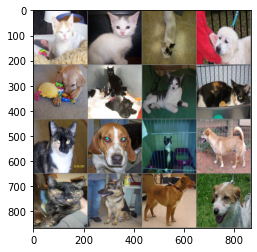

In [7]:
print(images.shape)
imshow(torchvision.utils.make_grid(images, nrow=4))
print(images.shape)
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(16)))

(3, 214, 214)
(214, 214, 3)
dog


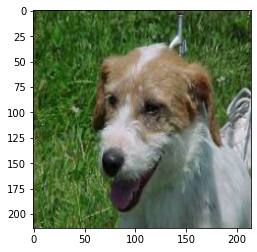

In [8]:
imshow(images[15])
print(classes[labels[15]])

In [9]:
from tqdm.notebook import tqdm

In [10]:
from model.VGG import VGG
# from model.CNN import CNN
# from model.ResNet import ResNet

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model = CNN().to(device)
# model = VGG(base_dim=16, num_classes=2).to(device)
model = VGG('A', num_classes=2).to(device)
# model = ResNet(base_dim = 32, num_classes=2).to(device)
print(model)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [11]:
# Train
for epoch in tqdm(range(25)):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    train_loss = 0.0

    # Train
    model.train()
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;        
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        # 통계를 출력합니다.
        running_loss += loss.item()
        train_loss += loss.item()

        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] training loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    train_loss /= len(trainloader)
    # Validation
    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            # Validation Loss
            loss = loss_func(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(valloader)
        val_acc = 100 * correct / total

    print('Epoch {}, Train Loss: {:.2f}, Val Loss: {:.2f}, Val Acc: {:.2f}'.format(epoch, train_loss, val_loss, val_acc))

# Measure Test Accuracy

correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = 100 * correct / total
print('Test Acc: {}%'.format(test_acc))


Epoch 0, Train Loss: 0.68, Val Loss: 0.67, Val Acc: 60.02
Epoch 1, Train Loss: 0.63, Val Loss: 0.57, Val Acc: 69.77
Epoch 2, Train Loss: 0.57, Val Loss: 0.55, Val Acc: 74.27
Epoch 3, Train Loss: 0.48, Val Loss: 0.48, Val Acc: 76.39
Epoch 4, Train Loss: 0.41, Val Loss: 0.47, Val Acc: 78.26
Epoch 5, Train Loss: 0.35, Val Loss: 0.46, Val Acc: 79.76
Epoch 6, Train Loss: 0.28, Val Loss: 0.41, Val Acc: 83.32
Epoch 7, Train Loss: 0.21, Val Loss: 0.40, Val Acc: 84.51
Epoch 8, Train Loss: 0.17, Val Loss: 0.40, Val Acc: 85.32
Epoch 9, Train Loss: 0.12, Val Loss: 0.45, Val Acc: 84.20
Epoch 10, Train Loss: 0.09, Val Loss: 0.49, Val Acc: 86.01
Epoch 11, Train Loss: 0.06, Val Loss: 0.59, Val Acc: 81.82
Epoch 12, Train Loss: 0.05, Val Loss: 0.71, Val Acc: 85.26
Epoch 13, Train Loss: 0.05, Val Loss: 0.65, Val Acc: 84.76
Epoch 14, Train Loss: 0.04, Val Loss: 0.61, Val Acc: 85.26
Epoch 15, Train Loss: 0.03, Val Loss: 0.76, Val Acc: 85.57
Epoch 16, Train Loss: 0.04, Val Loss: 0.66, Val Acc: 85.32
Epoch 1

In [12]:
def imshow(img):
    img = img/2 + 0.5 # unnormalize
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    
    print(np_img.shape)
    print((np.transpose(np_img, (1, 2, 0))).shape)

In [13]:
sample = torchvision.datasets.ImageFolder(root='./ahri', transform=trans)
sampleloader = DataLoader(sample, batch_size=4, shuffle=False, num_workers=4) 
dataiter = iter(sampleloader)
images, labels = dataiter.next()

(3, 434, 434)
(434, 434, 3)
torch.Size([3, 218, 866])
  cat   cat   cat   cat 


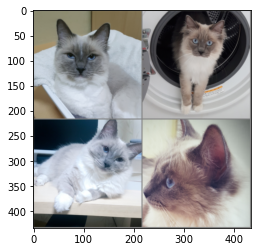

In [14]:
imshow(torchvision.utils.make_grid(images, nrow=2))
print((torchvision.utils.make_grid(images)).shape)
print("".join("%5s "%classes[labels[j]] for j in range(4)))

In [15]:
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
outputs

tensor([[ 8.4128, -7.4658],
        [-1.9617,  2.0256],
        [ 5.5045, -5.6708],
        [ 4.2563, -4.3252]], device='cuda:0', grad_fn=<AddmmBackward>)

In [16]:
print('Predicted:', ', '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   cat,   dog,   cat,   cat
